In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
from tqdm.notebook import tqdm
import skimage.io
import albumentations as albu
import tensorflow as tf

In [3]:
from tensorflow.keras.utils import Sequence
from keras.callbacks import Callback

In [4]:
#러닝레이트 조정
#https://pypi.org/project/keras-swa/
from swa.keras import SWA
import math

In [5]:
#GPU 사용하는 만큼만 사용
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

## Data call

In [6]:
!pwd

/home/workspace/user-workspace/Crack/madfalcon


In [7]:
img_dir = '/home/workspace/data/.train/.task153/data/train/'
task_dir = '/home/workspace/data/.train/.task153/data/train/'
custom_dir = '/home/workspace/user-workspace/Crack/madfalcon/trans_data/'
df = pd.read_csv(task_dir+'train.csv',names=['file','tile','label'],sep=',',skiprows=1)
#image_file_list = glob(task_dir+ '/**/*.tif', recursive=True)

## Data analysis

In [8]:
normal_img_len = len(df[df['label'] == 0]['file'])
normal_df = df[df['label'] == 0]
normal_df.reset_index(inplace=True, drop=True)

crack_img_len = len(df[df['label'] == 1]['file'])
crack_df = df[df['label'] == 1]
crack_df.reset_index(inplace=True, drop=True)

print(f'normal image : {normal_img_len}')
print(f'crack image : {crack_img_len}')

normal image : 12579
crack image : 1494


In [12]:
IMG_SIZE = 34 #타일별 이미지 사이즈
SEQ_LEN = 4 # 16^2 = 256, 2 * 34 = 68 * 68 사이즈의 이미지를 생성
BATCH_SIZE = 30
SEED = 2020

In [13]:
class Datatile(Sequence):
    #initialize
    def __init__(self, imgs_path, df, batch_size=32, 
                 mode='fit', shuffle=False, aug=None, 
                 seq_len=12, img_size=128, n_classes=6):
        self.imgs_path = imgs_path
        self.df = df
        self.shuffle = shuffle
        self.mode = mode
        self.aug = aug
        self.batch_size = batch_size
        self.img_size = img_size
        self.seq_len = seq_len
        self.n_classes = n_classes
        self.side = int(seq_len ** .5)
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        X = np.zeros((self.batch_size, self.side * self.img_size, self.side * self.img_size, 3), dtype=np.float32)
        imgs_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['file'].values
        for i, img_name in enumerate(imgs_batch):
            img_path = '{}'.format(self.imgs_path+img_name)
            print(img_name, end=' ')
            img_patches = self.get_patches(img_path)
            X[i, ] = self.glue_to_one(img_patches)
        if self.mode == 'fit':
            y = np.zeros((self.batch_size, self.n_classes), dtype=np.float32)
            lbls_batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]['label'].values
            for i in range(self.batch_size):
                y[i, lbls_batch[i]] = 1
            return X, y
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('mode parameter error')
            
    def get_patches(self, img_path):
        num_patches = self.seq_len
        p_size = self.img_size
        img = skimage.io.MultiImage(img_path)[0] / 255
        if self.aug:
            img = self.aug(image=img)['image'] 
        pad0, pad1 = (p_size - img.shape[0] % p_size) % p_size, (p_size - img.shape[1] % p_size) % p_size
        img = np.pad(
            img,
            [
                [pad0 // 2, pad0 - pad0 // 2], 
                [pad1 // 2, pad1 - pad1 // 2], 
                [0, 0]
            ],
            constant_values=1
        )
        img = img.reshape(img.shape[0] // p_size, p_size, img.shape[1] // p_size, p_size, 3)
        img = img.transpose(0, 2, 1, 3, 4).reshape(-1, p_size, p_size, 3)
        if len(img) < num_patches:
            img = np.pad(
                img, 
                [
                    [0, num_patches - len(img)],
                    [0, 0],
                    [0, 0],
                    [0, 0]
                ],
                constant_values=1
            )
        idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:num_patches]
        return np.array(img[idxs])
    def glue_to_one(self, imgs_seq):
        img_glue = np.zeros((self.img_size * self.side, self.img_size * self.side, 3), dtype=np.float32)
        #img_size * side 만큼 float32비트 형식으로 0으로 채움
#         print(f"img_glue size : {img_glue.shape} , imgs_seq size : {imgs_seq.shape}")
        for i, ptch in enumerate(imgs_seq):
            x = i // self.side
            y = i % self.side
#             print(f"ptch size : {ptch.shape} , x : {x} , y : {y}  ")
            img_glue[x * self.img_size : (x + 1) * self.img_size, 
                     y * self.img_size : (y + 1) * self.img_size, :] = ptch
        return img_glue

## Training model

In [16]:

from keras import backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

#efn model
import efficientnet.tfkeras as efn

In [17]:
from keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [23]:
def ModelCNN_resnet50():
    input = Input(shape=(224, 224, 3))
    model = Sequential()
    bottleneck = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_tensor=input)
    model.add(bottleneck)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.6))
    model.add(Dense(2, activation='softmax'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=1e-5),
        metrics=['categorical_accuracy',precision, recall, f1score]
    )
    return model


def ModelCNN_resnet152():
    input = Input(shape=(68, 68, 3))
    model = Sequential()
    bottleneck = ResNet152(weights='imagenet', include_top=False, pooling='avg', input_tensor=input)
    model.add(bottleneck)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(2, activation='softmax'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=1e-5),
        metrics=['categorical_accuracy',precision, recall, f1score]
    )
    return model

def ModelCNN_InceptionResNetV2():
    input = Input(shape=(68, 68, 3))
    model = Sequential()
    bottleneck = inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg', input_tensor=input)
    model.add(bottleneck)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(2, activation='softmax'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=1e-5),
        metrics=['categorical_accuracy',precision, recall, f1score]
    )
    return model

def ModelCNN_resnext101():
    input = Input(shape=(68, 68, 3))
    model = Sequential()
    bottleneck = ResNeXt101(weights='imagenet', include_top=False, pooling='avg', input_tensor=input)
    model.add(bottleneck)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.25))
    model.add(Dense(2, activation='softmax'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=1e-5),
        metrics=['categorical_accuracy',precision, recall, f1score]
    )
    return model


def ModelCNN_efnb7():
#     input = Input(shape=(68, 68, 3))
    input_val = Input(shape=(156, 156, 3))
    model = Sequential()
    bottleneck = efn.EfficientNetB7(input_shape=(156, 156, 3),weights='noisy-student',include_top=False)
    model.add(bottleneck)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='gelu'))
    model.add(BatchNormalization())
    model.add(Dropout(.6))
    model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001, epsilon=0.001,decay=1e-5, clipnorm=1.),
        metrics=['categorical_accuracy',precision, recall, f1score]
    )
    return model

def ModelCNN_efnb5():
#     input = Input(shape=(68, 68, 3))
    input_val = Input(shape=(224, 224, 3))
    model = Sequential()
    bottleneck = efn.EfficientNetB5(input_shape=(224, 224, 3),weights='noisy-student',include_top=False)
    model.add(bottleneck)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='gelu',kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(.6))
    model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))
    model.summary()

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001, epsilon=0.001,decay=1e-5, clipnorm=1.),
        metrics=['categorical_accuracy',precision, recall, f1score]
    )
    return model

In [24]:
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import KFold
random_seed = 2020
kf = KFold(n_splits=4)

In [25]:
# gelu activation function -  Gaussian Error Linear Units (GELUs)
# https://arxiv.org/abs/1606.08415

from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
class Gelu(Activation):
    def __init__(self, activation, **kwargs):
        super(Gelu, self).__init__(activation, **kwargs)
        self.__name__='gelu'
        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

get_custom_objects().update({'gelu': Gelu(gelu)})

In [26]:
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose == 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)
        

def build_lrfn(lr_start=0.00001, lr_max=0.00005,lr_min=0.00001, lr_rampup_epochs=5,lr_sustain_epochs=0, lr_exp_decay=.8):
    
#     lr_max = lr_max * strategy.num_replicas_in_sync
    lr_max = lr_max * 8
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs- lr_sustain_epochs) + lr_min
        return lr
    return lrfn

aug = albu.Compose(
    [
        albu.HorizontalFlip(p=.5),
        albu.VerticalFlip(p=.5),
#         albu.ShiftScaleRotate(shift_limit=.1, scale_limit=.1, rotate_limit=20, p=.25)
    ]
)

In [27]:
# model = ModelCNN_resnet50()
# model = ModelCNN_resnet152()
# model = ModelCNN_InceptionResNetV2()
# model = ModelCNN_resnext101()
# model = ModelCNN_efnb7()
model = ModelCNN_efnb5()

model_file = 'best_efnb5_1_224_.h5'
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                            patience=3, 
#                                            verbose=1, 
#                                            factor=0.5, 
#                                            min_lr=0.00001)
epochs = 50
EarlyStopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=7,verbose=True, mode="min")
modelsaver = tf.keras.callbacks.ModelCheckpoint(
    model_file, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True,
    mode='min'
)
start_epoch = 4
swa = SWA(start_epoch=start_epoch, 
          lr_schedule='cyclic', 
          swa_lr  = 0.000001,
          swa_lr2 = 0.000009,
          swa_freq=3,
          batch_size = 30,
          verbose=1)

cosine_scheduler = CosineAnnealingScheduler(T_max=100, eta_max=3e-4, eta_min=1e-6)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Functional) (None, 7, 7, 2048)        28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 29,565,682
Trainable params: 29,391,922
Non-trainable params: 173,760
____________________________________

(224, 224, 3)


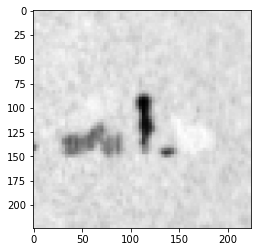

In [28]:
def read_image(image_path, resize_ratio=3.3):
    if not(isinstance(image_path, str)):
        # if tensor with byte string
        image_path = image_path.numpy().decode('utf-8')

    image_level_1 = skimage.io.MultiImage(image_path)[0]
    
    if resize_ratio != 1:
        new_w = int(image_level_1.shape[1]*resize_ratio)
        new_h = int(image_level_1.shape[0]*resize_ratio)
        image_level_1 = cv2.resize(
            image_level_1, (new_w, new_h), interpolation=cv2.INTER_AREA)
        image_level_1 = cv2.normalize(image_level_1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return image_level_1


image = read_image(task_dir + '23.tif')
print(image.shape)
plt.imshow(image)

## Predict Crack tile

In [26]:
# saved model call

from tensorflow import keras
save_model = keras.models.load_model("best_efnb7_7.h5",
                                              custom_objects={
                                                  'recall': recall,
                                                  'precision': precision,
                                                  'f1score' : f1score,
                                                  'Gelu' : Gelu(gelu)
                                              }
                                             )

In [27]:
test_PATH = '/home/workspace/data/.train/.task153/data/test/'
test_df = pd.read_csv('/home/workspace/data/.train/.task153/data/test/test.csv',names=['file','tile','label'],sep=',',skiprows=1)
test_N = test_df.shape[0]
test_x = np.empty((test_N,156,156,3), dtype=np.uint8)
for i,path in enumerate(tqdm(test_df.file)): 
    image = read_image(test_PATH + path)
    test_x[i,:,:,:] =  image

In [28]:
# preds = model.predict_generator(test_datagen)
preds = save_model.predict(test_x)
print('preds done, total:', len(preds))

test_df['label'] = np.argmax(preds, axis=1)
print(test_df.label.value_counts())
test_df.to_csv('submission_best_efnb7_7.csv', index=False)
print('submission saved')

preds done, total: 9192
0    8324
1     868
Name: label, dtype: int64
submission saved


In [29]:
#제출파일 생성
test_df.label.to_csv('/home/workspace/user-workspace/prediction/prediction.csv',header=None,index=None)

In [27]:
# test_df = pd.read_csv('/home/workspace/data/.train/.task153/data/test/test.csv',names=['file','tile','label'],sep=',',skiprows=1)
# preds = [[0] * 2] * len(test_df)
# test_datagen = Datatile(
#     imgs_path='/home/workspace/data/.train/.task153/data/test/', 
#     df=test_df,
#     batch_size=1,
#     mode='predict', 
#     shuffle=False, 
#     aug=None, 
#     seq_len=SEQ_LEN, 
#     img_size=IMG_SIZE, 
#     n_classes=2
# )
# # preds = model.predict_generator(test_datagen)
# preds = model.predict_generator(test_datagen)
# print('preds done, total:', len(preds))

# test_df['label'] = np.argmax(preds, axis=1)
# print(test_df.label.value_counts())
# test_df.to_csv('submission_trans_efnb7.csv', index=False)
# print('submission saved')

# #제출파일 생성
# test_df.label.to_csv('/home/workspace/user-workspace/prediction/prediction.csv',header=None,index=None)

In [28]:
# import pandas as pd
# result_df = pd.read_csv('submission_aug_resnet50_47.csv',names=['file','tile','label'],sep=',',skiprows=1)
# print(result_df.label.value_counts())